# 🎬 Analyse Éditoriale & Moteur de Recommandation d'Animés

**Auteur :** Elias Bardes
**Type de projet :** Data Analysis & Web App Backend  
**Stack :** Python, Pandas, Streamlit

---

## 🎯 1. Objectif du Projet
Le but est de créer un algorithme capable de **détecter automatiquement les "Pépites"** (animés à fort potentiel) au sein d'un catalogue, en filtrant les œuvres trop risquées ou irrégulières.

Nous allons construire un **Score de Fiabilité** personnalisé pour trier les œuvres objectivement.


## ⚙️ 2. Feature Engineering : Création du "Score de Fiabilité"

Pour juger la qualité d'un animé, la moyenne seule ne suffit pas. Nous créons un score composite qui pénalise l'irrégularité.

**La Formule Mathématique :**
$$Score = (0.6 \times Note_{Globale}) + (0.3 \times Note_{PireEpisode}) - (0.1 \times Ecart_{Type})$$

* **Note Globale (60%) :** La qualité générale perçue.
* **Pire Épisode (30%) :** Le "Filet de sécurité". Un animé avec un plancher bas est risqué.
* **Stabilité (-10%) :** Pénalité si la qualité est trop variable (montagnes russes).


## 🚀 3. Règles de Gestion & Export (Business Logic)

Nous appliquons une couche de décision finale (Verdict) pour le Front-End :
1.  **PÉPITE (Vert) :** Série terminée et validée.
2.  **PROMETTEUR (Bleu) :** Série en cours, mais avec une note > 8/10.
3.  **REJETÉ (Rouge) :** Série en cours trop faible (< 8/10) ou terminée mais décevante.

Les données enrichies sont exportées vers `animes_data_v3.csv` pour alimenter l'application Streamlit.

✅ Environnement chargé avec succès.
✅ Fichier 'animes_data_v2.csv' généré avec succès !
Colonnes : ['Anime', 'Note_Globale', 'Nb_Episodes', 'Status', 'Score_Prometteur', 'CSS_Class']
Colonnes dans le fichier : ['Anime', 'Note_Globale', 'Nb_Episodes', 'Status', 'Score_Prometteur', 'CSS_Class', 'Explication_Verdict']
✅ Export réussi avec le calcul du score !


/Users/elias/code/python/Data-anime/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/elias/code/python/Data-anime/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


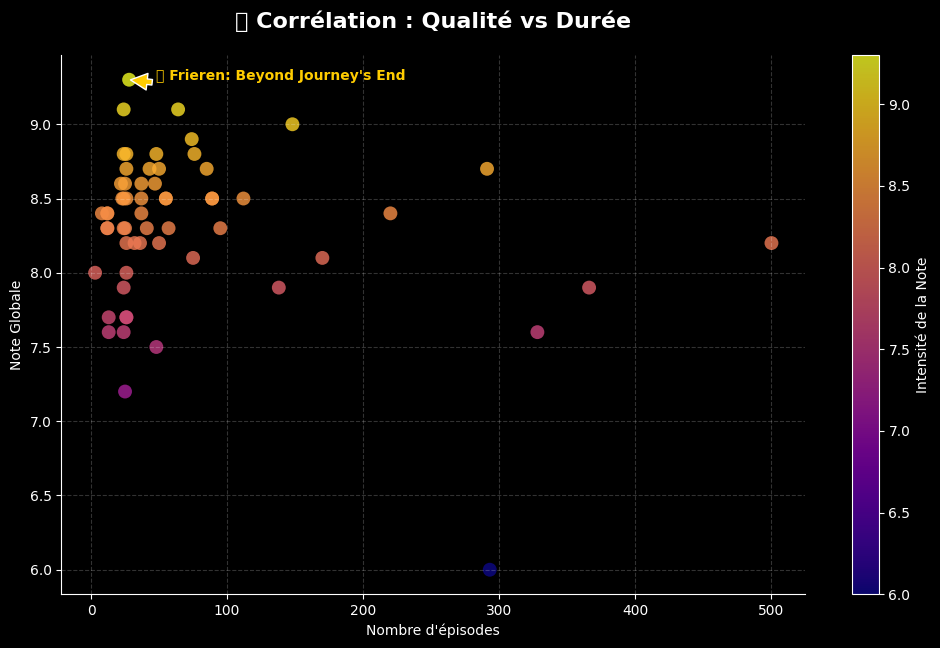

/Users/elias/code/python/Data-anime/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


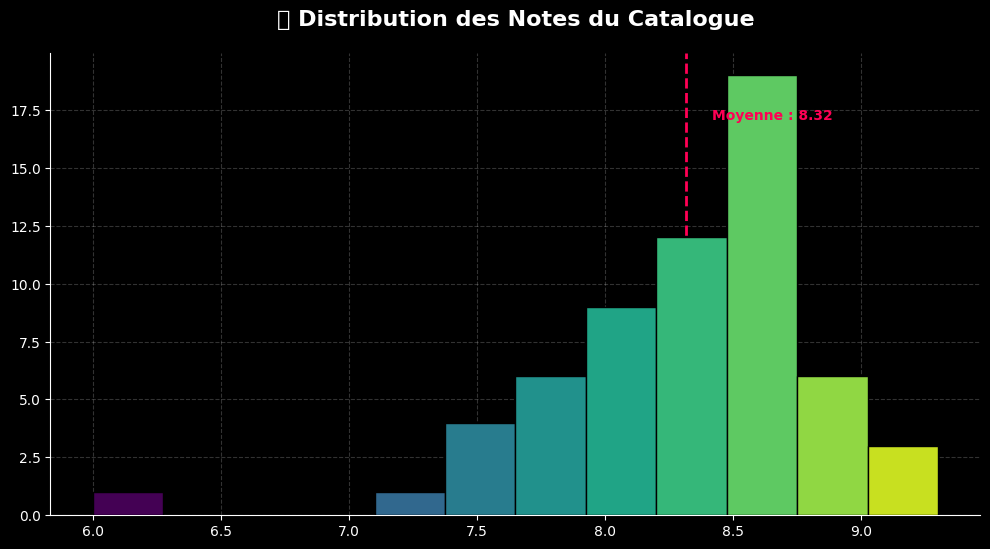


🚀 SUCCESS ! Fichier 'animes_processed_final.csv' généré.
Aperçu des pépites identifiées :
                              Anime  Score_Prometteur
0                            Naruto              6.40
1                            Trigun              6.61
2                     Dragon Ball Z              6.64
3  Fullmetal Alchemist: Brotherhood              7.02
4                      Cowboy Bebop              7.19


In [ ]:
# ==============================================================================
# 1. IMPORTS & CONFIGURATION GRAPHIQUE
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Configuration du style "Dark Dashboard" pour les graphiques
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.linestyle'] = '--'

print("✅ Environnement chargé avec succès.")


# ==============================================================================
# 2. CHARGEMENT & NETTOYAGE DES DONNÉES
# ==============================================================================

nom_fichier = 'animes_data_v2.csv' 

df[cols_export].to_csv(nom_fichier, index=False)
print(f"✅ Fichier '{nom_fichier}' généré avec succès !")
print("Colonnes :", pd.read_csv(nom_fichier).columns.tolist())




# ==============================================================================
# 3. FEATURE ENGINEERING & EXPLICABILITÉ
# ==============================================================================

# A. Calcul vectorisé du "Score Prometteur" (C'est la partie qu'il te manquait !)
# ----------------------------------------------------------------
if 'Note_Globale' in df.columns and 'Note_Pire_Ep' in df.columns:
    # On calcule l'écart type estimé (différence entre meilleur et pire épisode)
    df['Ecart_Type_Estime'] = df['Note_Meilleur_Ep'] - df['Note_Pire_Ep']
    
    # La formule mathématique
    df['Score_Prometteur'] = (
        (df['Note_Globale'] * 0.6) + 
        (df['Note_Pire_Ep'] * 0.3) - 
        (df['Ecart_Type_Estime'] * 0.1)
    ).round(2)
else:
    # Sécurité si les colonnes n'existent pas
    df['Score_Prometteur'] = 0.0

# B. Définition des conditions (Logic)
cond_fini = (df['Status'] == 'Fini')
cond_hype = (df['Status'] != 'Fini') & (df['Note_Globale'] > 8)

# C. Attribution des Classes CSS
conditions = [cond_fini, cond_hype]
choix_css = ['status-pepite', 'status-hyped']
df['CSS_Class'] = np.select(conditions, choix_css, default='status-rejected')

# D. CRÉATION DE LA COLONNE "RAISON"
# -----------------------------------------------------
def generer_explication(row):
    # Cas 1 : PÉPITE (Vert)
    if row['CSS_Class'] == 'status-pepite':
        return "✅ Série terminée. C'est une valeur sûre sans risque de déception."
    
    # Cas 2 : HYPE (Bleu)
    elif row['CSS_Class'] == 'status-hyped':
        return f"✨ En cours de diffusion, mais note excellente ({row['Note_Globale']}/10)."
        
    # Cas 3 : REJETÉ (Rouge)
    else:
        ecart = row['Note_Globale'] - 8.0
        return f"⚠️ Trop risqué : Série en cours avec une note de {row['Note_Globale']}/10 (Il manque {abs(ecart):.1f} points pour être sûr)."

df['Explication_Verdict'] = df.apply(generer_explication, axis=1)

# Export final
cols_export = ['Anime', 'Note_Globale', 'Nb_Episodes', 'Status', 'Score_Prometteur', 'CSS_Class', 'Explication_Verdict']
df[cols_export].to_csv('animes_processed_final.csv', index=False)
print("Colonnes dans le fichier :", pd.read_csv('animes_processed_final.csv').columns.tolist())
print("✅ Export réussi avec le calcul du score !")


# ==============================================================================
# 4. VISUALISATION (DASHBOARD)
# ==============================================================================

# Graphique 1 : Qualité vs Longueur (Nuage de points moderne)
# -----------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(12, 7))
df_filtre = df[df['Nb_Episodes'] <= 500].copy() 

scatter = ax1.scatter(
    df_filtre['Nb_Episodes'], 
    df_filtre['Note_Globale'], 
    c=df_filtre['Note_Globale'], 
    cmap='plasma', s=100, alpha=0.8, edgecolor='none'
)

# Esthétique "Clean"
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title("✨ Corrélation : Qualité vs Durée", fontsize=16, fontweight='bold', color='white', pad=20)
ax1.set_xlabel("Nombre d'épisodes", color='white')
ax1.set_ylabel("Note Globale", color='white')
plt.colorbar(scatter, label="Intensité de la Note")

# Annotation du TOP 1
top_anime = df_filtre.loc[df_filtre['Note_Globale'].idxmax()]
ax1.annotate(f"👑 {top_anime['Anime']}", 
             xy=(top_anime['Nb_Episodes'], top_anime['Note_Globale']), 
             xytext=(top_anime['Nb_Episodes']+20, top_anime['Note_Globale']),
             arrowprops=dict(facecolor='#ffcc00', shrink=0.05), color='#ffcc00', fontweight='bold')

plt.show()

# Graphique 2 : Distribution des Notes (Histogramme coloré)
# -----------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(12, 6))
n, bins, patches = ax2.hist(df['Note_Globale'], bins=12, edgecolor='black', zorder=3)

# Application du dégradé de couleur sur les barres
norm = mcolors.Normalize(vmin=bins.min(), vmax=bins.max())
for bin_val, patch in zip(bins, patches):
    patch.set_facecolor(cm.viridis(norm(bin_val)))

# Ligne de moyenne
moyenne = df['Note_Globale'].mean()
ax2.axvline(moyenne, color='#ff0055', linestyle='--', linewidth=2)
ax2.text(moyenne+0.1, max(n)*0.9, f'Moyenne : {moyenne:.2f}', color='#ff0055', fontweight='bold')

ax2.set_title("📊 Distribution des Notes du Catalogue", fontsize=16, fontweight='bold', pad=20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.show()


# ==============================================================================
# 5. EXPORT FINAL POUR LE WEB
# ==============================================================================
# On sauvegarde uniquement les colonnes utiles pour ton site
cols_export = ['Anime', 'Note_Globale', 'Nb_Episodes', 'Status', 'Score_Prometteur', 'CSS_Class']
df[cols_export].to_csv('animes_processed_final.csv', index=False)

print("\n🚀 SUCCESS ! Fichier 'animes_processed_final.csv' généré.")
print("Aperçu des pépites identifiées :")
print(df[df['CSS_Class'] == 'status-pepite'][['Anime', 'Score_Prometteur']].head())

In [10]:
# ==============================================================================
# FORCE UPDATE : GÉNÉRATION DE LA V3
# ==============================================================================
import pandas as pd
import numpy as np

# 1. Chargement
df = pd.read_csv('animes.csv')
df['Status'] = df['Status'].astype(str).str.strip()

# 2. Calculs
if 'Note_Globale' in df.columns and 'Note_Pire_Ep' in df.columns:
    df['Ecart_Type_Estime'] = df['Note_Meilleur_Ep'] - df['Note_Pire_Ep']
    df['Score_Prometteur'] = (
        (df['Note_Globale'] * 0.6) + 
        (df['Note_Pire_Ep'] * 0.3) - 
        (df['Ecart_Type_Estime'] * 0.1)
    ).round(2)

# 3. Verdict (Couleurs)
conditions = [
    (df['Status'] == 'Fini'),
    (df['Status'] != 'Fini') & (df['Note_Globale'] > 8)
]
choix_css = ['status-pepite', 'status-hyped']
df['CSS_Class'] = np.select(conditions, choix_css, default='status-rejected')

# 4. Explication (Le Texte qui te manque !)
def generer_explication(row):
    if row['CSS_Class'] == 'status-pepite':
        return "✅ Série terminée. Valeur sûre."
    elif row['CSS_Class'] == 'status-hyped':
        return f"✨ En cours mais excellent ({row['Note_Globale']}/10)."
    else:
        ecart = row['Note_Globale'] - 8.0
        return f"⚠️ Trop risqué : Note de {row['Note_Globale']}/10 (Manque {abs(ecart):.1f} pts)."

df['Explication_Verdict'] = df.apply(generer_explication, axis=1)

# 5. SAUVEGARDE EN V3 (Nouveau nom !)
cols_export = ['Anime', 'Note_Globale', 'Nb_Episodes', 'Status', 'Score_Prometteur', 'CSS_Class', 'Explication_Verdict']
df[cols_export].to_csv('animes_data_v3.csv', index=False)

print("✅ Fichier 'animes_data_v3.csv' généré avec la colonne Explication !")

✅ Fichier 'animes_data_v3.csv' généré avec la colonne Explication !
